## 청라, 송도지역 미세먼지 측정값 스크래핑
> 1. 송도 = https://bit.ly/2EWi9vM
> 1. 청라 = https://bit.ly/2Al7h6y

* Todo: 계측 센서 갯수가 다르므로 필터링 방식이 달라져야 한다
* 송도 = 6개 / 청라 = 4개

## Release Note ... rel.2019.1/3 (Thu)
1. 센서값이 순서상 꺼꾸로 누적 ... DataFrame 만들때, 처음부터 순서를 뒤집음
1. 그래프를 물리적으로 뒤집는 flip() 함수 삭제

In [1]:
"""
* 청라, 송도지역 미세먼지 측정값 스크래핑
"""

import sys
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup

In [2]:
URLS = [
    'http://air.incheon.go.kr/airinch/real3.html?area_other_index=999991',
    'http://air.incheon.go.kr/airinch/real3.html?area_other_index=999992',
]

""" 주의!: 송도와 청라는 데이터 갯수가 틀려서 필터링 방법을 달리해야 함. """
URL = URLS[0]  # 0=청라 - 측정치 1+3 = 4개
URL = URLS[1]  # 1=송도 - 측정치 1+6 = 7개

RESPONSE = requests.get(URL)
SOUP = BeautifulSoup(RESPONSE.content, 'html.parser')
TABLE = SOUP.find_all('table', {'class': 'view'})

TDS = TABLE[0].find_all('td')
FONTS = TABLE[0].find_all('font')
SPANS = TABLE[0].find_all('span')

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


## 데이터의 길이를 기준으로 구분한다 (EDA)
> 12자 길이를 넘어가는 데이터는 한글 테이터이다.

In [3]:
for n, span in enumerate(SPANS, 0):
    neat_span = str(span.text).strip()   

In [4]:
DATE = []       # 날짜정보 2개를 담음.
DATA = []       # 스크랩핑한 전체 데이터 = 헤드정보 포함

In [5]:
for n, span in enumerate(SPANS, 0):
    neat_span = str(span.text).strip()

    if len(neat_span) > 12:                           # 2018년12월 29일24시
        """ 날짜와 시간을 분리해서 각각 넣는다 """
        DATE.append(neat_span[:-3])     # 날짜 = 2018년 12월 29일
        DATA.append(neat_span[-3:])     # 시간 = '24시'  .. 날짜는 잘라내고, 시간만 넣는다
    else:
        DATA.append(neat_span)          # 그렇지 않으면 그냥 넣는다

""" 리스트에 담긴 해당 날짜를 보여준다, 그래봤자 2개 지만.. """
1. print(DATE[0])                          # 2018년12월 30일  ... 오늘날짜가 먼저 담긴다.
1. print(DATE[1])                          # 2018년12월 29일  ... 어제날짜가 다음에 담긴다.

In [6]:
DATE
# '2019년01월\xa003일', '2019년01월\xa002일']

# DATA[:8]
# ['시간', '측정항목', 'SO2(ppm)', 'NO2(ppm)', 'O3(ppm)', 'CO(ppm)', 'PM10(㎍/㎥)', 'PM2.5(㎍/㎥)', 
#  '11시', '0.009', '0.056',..... ]
# 맨 앞의 8자리 해더정보를 잘라내고 데이터만 DATA 에 담는다

['2019년01월\xa006일', '2019년01월\xa005일']

In [7]:
DATE[0]     # 오늘 ... '2019년01월\xa003일'
DATE[1]     # 어제 ... '2019년01월\xa002일'
FORMAT_DATE = []

for date in DATE:
    YEAR =  date[:4]     # '2009'
    MONTH = date[5:7]    # '01'
    DAY =   date[9:-1]   # '03'
    FORMAT_DATE.append(f'{YEAR}-{MONTH}-{DAY}')             

FORMAT_DATE.reverse()   # ['2019-01-02', '2019-01-03']

In [8]:
FORMAT_DATE

['2019-01-05', '2019-01-06']

In [9]:
FULL_COLUMNS = ['Time(24Hr)',]
FULL_COLUMNS.extend(DATA[2:8])  # ['Time(24Hr)','SO2(ppm)', ... 'CO(ppm)','PM10(㎍/㎥)','PM2.5(㎍/㎥)']

## COLUMNS, UNIT, TIME_COLS
1. COLUMNS = ['Time', 'SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5'],
1. UNITS = ['24Hr', 'ppm', 'ppm', 'ppm', 'ppm', '㎍/㎥', '㎍/㎥'])    
1. TIME_COLS = ['01', '02', ... '12', '01',]
1. FORMAT_DATE = ['2019-01-02', '2019-01-03']  ... 순서대로 재배열

In [10]:
COLUMNS = []       # 컬럼 제목들 만 뽑는다.
UNITS = []         # 컬럼 단위들 만 뽑는다.

for item in FULL_COLUMNS:      # full 컬럼값에서 '타이틀'과 '단위'를 분리해 냄
    title = item.split('(')[0]    # Title
    _rest = item.split('(')[1]
    
    COLUMNS.append(title)
    UNITS.append(_rest[:-1])

In [11]:
CUT_DATA = DATA[8:]                       # 앞 부분(index header)을 잘라내고 데이터부분만 남김 =  1-DIM
DATA_NP = np.array(CUT_DATA)              # numpy 데이터 변환!
DATA_NP2D = np.reshape(DATA_NP, (-1,7))   # 1D to 2D 변환 (-1,7)
# np.shape(a=DATA_NP2D)                     # (26,7)  ... 그때 그때 행이 바뀜, 최대 24~ 48까지
DATA_NP2D

array([['20시', '0.006', '0.030', '0.020', '0.5', '32', '16'],
       ['19시', '0.006', '0.020', '0.029', '0.6', '29', '16'],
       ['18시', '0.005', '0.014', '0.033', '0.4', '25', '10'],
       ['17시', '0.006', '0.010', '0.038', '0.4', '29', '14'],
       ['16시', '0.006', '0.009', '0.039', '0.4', '29', '10'],
       ['15시', '0.006', '0.010', '0.037', '0.4', '36', '15'],
       ['14시', '0.008', '0.016', '0.031', '0.5', '45', '18'],
       ['13시', '0.009', '0.020', '0.029', '0.5', '56', '23'],
       ['12시', '0.010', '0.023', '0.021', '0.6', '59', '26'],
       ['11시', '0.011', '0.031', '0.015', '0.6', '62', '31'],
       ['10시', '0.013', '0.033', '0.010', '0.7', '64', '29'],
       ['09시', '0.010', '0.035', '0.008', '0.6', '54', '23'],
       ['08시', '0.008', '0.039', '0.005', '0.6', '54', '22'],
       ['07시', '0.008', '0.036', '0.007', '0.7', '56', '23'],
       ['06시', '0.008', '0.025', '0.016', '0.6', '58', '24'],
       ['05시', '0.008', '0.023', '0.017', '0.6', '59', '26'],
       [

In [12]:
TIME_COLS = DATA_NP2D[:,0]                         # 시간 1열만 쪼개서 따로 담음 .. '08시'
DATA_NP2D[:,0] = [time[:2] for time in TIME_COLS]  # 02시 --> 02, 앞 두글자만 잘라냄
DATA_NP2D[:10]

array([['20', '0.006', '0.030', '0.020', '0.5', '32', '16'],
       ['19', '0.006', '0.020', '0.029', '0.6', '29', '16'],
       ['18', '0.005', '0.014', '0.033', '0.4', '25', '10'],
       ['17', '0.006', '0.010', '0.038', '0.4', '29', '14'],
       ['16', '0.006', '0.009', '0.039', '0.4', '29', '10'],
       ['15', '0.006', '0.010', '0.037', '0.4', '36', '15'],
       ['14', '0.008', '0.016', '0.031', '0.5', '45', '18'],
       ['13', '0.009', '0.020', '0.029', '0.5', '56', '23'],
       ['12', '0.010', '0.023', '0.021', '0.6', '59', '26'],
       ['11', '0.011', '0.031', '0.015', '0.6', '62', '31']], dtype='<U5')

In [13]:
# TEST!
# numpy.flip  ...  SciPy Documentation
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.flip.html

_a = [
    [1, 2, 3], 
    [4, 5, 6], 
    [7, 8, 9],
]
_a_np = np.array(_a)

_a_np_fliped = np.flip(_a_np, 1)    # 0 = 상하플립, 1 = 좌우플립
print(_a_np,'\n')
print(_a_np_fliped)

[[1 2 3]
 [4 5 6]
 [7 8 9]] 

[[3 2 1]
 [6 5 4]
 [9 8 7]]


In [14]:
DATA_NP2D_FLIPED = np.flip(DATA_NP2D, 0)    # 0=상하플립

DATA_NUM = len(DATA_NP2D_FLIPED)
INDEX = []

for i in range(DATA_NUM):
    if i < 23:
        INDEX.append(f'{FORMAT_DATE[0]}-{i+1:02}')
    else:
        INDEX.append(f'{FORMAT_DATE[1]}-{i-24+1:02}')
INDEX    # ['2019-01-02-01', '2019-01-02-02',


DATA_NP2D_FLIPED_LIST = DATA_NP2D_FLIPED.tolist()


for i in range(DATA_NUM):
   DATA_NP2D_FLIPED_LIST[i][0] = INDEX[i]

DATA_NP2D_FLIPED_LIST[:10]

[['2019-01-05-01', '0.008', '0.018', '0.038', '1.1', '101', '75'],
 ['2019-01-05-02', '0.008', '0.018', '0.033', '1.1', '131', '100'],
 ['2019-01-05-03', '0.009', '0.026', '0.023', '1.1', '113', '83'],
 ['2019-01-05-04', '0.010', '0.022', '0.026', '1.1', '122', '92'],
 ['2019-01-05-05', '0.009', '0.016', '0.030', '0.9', '102', '75'],
 ['2019-01-05-06', '0.010', '0.021', '0.023', '0.7', '64', '42'],
 ['2019-01-05-07', '0.017', '0.031', '0.014', '0.7', '54', '36'],
 ['2019-01-05-08', '0.009', '0.031', '0.014', '0.7', '54', '31'],
 ['2019-01-05-09', '0.009', '0.026', '0.018', '0.7', '43', '24'],
 ['2019-01-05-10', '0.007', '0.023', '0.021', '0.6', '42', '21']]

In [15]:
# TEST! 
# a[:,0] = ['1t','2','3']    # ValueError: invalid literal for int() with base 10: '1t'
a = np.zeros((3,5), dtype=np.int64)
a[:,0] = ['1234562389','21232345789','31232345689']   # str 인데 int64로 자동인식!
a

array([[ 1234562389,           0,           0,           0,           0],
       [21232345789,           0,           0,           0,           0],
       [31232345689,           0,           0,           0,           0]],
      dtype=int64)

In [16]:
DATA_NP2D_FLIPED = np.array(DATA_NP2D_FLIPED_LIST)
DATA_NP2D_FLIPED[:4]

array([['2019-01-05-01', '0.008', '0.018', '0.038', '1.1', '101', '75'],
       ['2019-01-05-02', '0.008', '0.018', '0.033', '1.1', '131', '100'],
       ['2019-01-05-03', '0.009', '0.026', '0.023', '1.1', '113', '83'],
       ['2019-01-05-04', '0.010', '0.022', '0.026', '1.1', '122', '92']],
      dtype='<U13')

In [17]:
DATA_NP2D_FLIPED[-4:-1]

array([['2019-01-06-17', '0.006', '0.010', '0.038', '0.4', '29', '14'],
       ['2019-01-06-18', '0.005', '0.014', '0.033', '0.4', '25', '10'],
       ['2019-01-06-19', '0.006', '0.020', '0.029', '0.6', '29', '16']],
      dtype='<U13')

In [18]:
# DATA_NP2D (String) 은 원본으로 남겨두고, Float 숫자로 변환하여 AIR_DATA_NP로 변경 
# AIR_DATA_NP = np.asfarray(DATA_NP2D, dtype=np.float)  # 문자열 --> float 로 변경해 줌(1)
AIR_DATA_NP = DATA_NP2D_FLIPED

In [19]:
# TEST ... Change data type of columns in Pandas (SOF)
# http://bit.ly/2LLSDcY

a = [['a', '1.2', '4.2'], ['b', '70', '0.03'], ['x', '5', '0']]

adf = pd.DataFrame(a, columns=['test1','test2','test3'])
# adf.test2 = pd.to_numeric(adf.test2)
# adf.test3 = pd.to_numeric(adf.test3)

for col in adf.columns[1:]:
    adf[col] = pd.to_numeric(adf[col])

adf

,test1,test2,test3
0,a,1.2,4.20
1,b,70.0,0.03
2,x,5.0,0.00


In [20]:
# Pandas DataFrame 오브젝트로 변경한다.
# df.index = df.Time      # 인덱스를 타임으로 변경함  .... 인덱스는 UID 중복 불가함(에러)

# df = df.drop('column_name', 1)
# where 1 is the axis number (0 for rows and 1 for columns.)
# df = df.drop('Time', 1) # 1=axis (column) / 0=rows  .... 1컬럼을 삭제하는 방법

df = pd.DataFrame(AIR_DATA_NP, columns=COLUMNS)
df.columns   # Index(['Time', 'SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5'], dtype='object')

for col in list(df.columns)[1:]:
    df[col] = pd.to_numeric(df[col])
    
df['Time'] = pd.to_datetime(df['Time'])    
    
    
# Dtype 변환 확인
# type(df['PM10'][0])      # numpy.int64
# type(df['PM2.5'][0])     # numpy.int64
# TEST ... Time Format

# time_format = '%d/%m/%y %H:00'
TIME_FORMAT = '%Y.%m/%d(%a)-%H:00'
TIMES = [ datetime.datetime.strftime(timestamp, TIME_FORMAT) for timestamp in df.Time.tolist()]
df['TIMES'] = TIMES
df.head()

,Time,SO2,NO2,O3,CO,PM10,PM2.5,TIMES
0,2019-01-05 01:00:00,0.008,0.018,0.038,1.1,101,75,2019.01/05(Sat)-01:00
1,2019-01-05 02:00:00,0.008,0.018,0.033,1.1,131,100,2019.01/05(Sat)-02:00
2,2019-01-05 03:00:00,0.009,0.026,0.023,1.1,113,83,2019.01/05(Sat)-03:00
3,2019-01-05 04:00:00,0.010,0.022,0.026,1.1,122,92,2019.01/05(Sat)-04:00
4,2019-01-05 05:00:00,0.009,0.016,0.030,0.9,102,75,2019.01/05(Sat)-05:00


In [21]:
# 그래프 함수의 정의

def df_plot(df_column): 
    # plt.figure(figsize=(10,4))
    plt.plot(df_column)
    """ 그래프에 텍스트를 입히는 옵션 """
    plt.title("DATA PLOTTING")        # 타이틀
    plt.xlabel(COLUMNS[:1])                      # x 라벨
    plt.ylabel(df_column.name)                   # y 라벨
    plt.legend()
    plt.xticks(df.index, df.TIMES, rotation=90)
    
def df_hist(df_column):
    plt.hist(df_column)
    """ 그래프에 텍스트를 입히는 옵션 """
    plt.title("DATA HISTOGRAM")        # 타이틀
    plt.xlabel(COLUMNS[:1])                      # x 라벨
    plt.ylabel(df_column.name)                   # y 라벨
    
    
def df_scatter(df_col1, df_col2):
    plt.scatter(df_col1, df_col2,alpha=0.2)
    """ 그래프에 텍스트를 입히는 옵션 """
    plt.title(
        "SCATTER CHART with {},{}".format(
            df_col1.name, 
            df_col2.name,))        # 타이틀
    plt.xlabel(df_col2.name)                     # x 라벨
    plt.ylabel(df_col1.name)                     # y 라벨
    
def plot_2charts(data_series, xlabel):  
    """
    # 히스토그램 + 박스플롯을 4x4화면 윗쪽 2개로 플롯해줍니다.
    """
    plt.figure()
    plt.subplot(221)
    plt.hist(data_series)
    plt.xlabel(xlabel)
    
    plt.subplot(222)
    sns.boxplot(data_series)
    plt.show()    

In [22]:
def plot_detail(pd_series, color='blue', marker='^', linestyle='--', xtick_interval=2, ytick_interval=5,):
    """
    style = color='blue', marker='^', linestyle='--'   ... default style
    linestyle = '-', '--', '-.', ':', '', (offset, on-off-seq), ...
    marker_style = '.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', 
                    's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_', 
    xtick_interval = 2, ytick_interval = 5
    https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html?highlight=plot%20color
    """
    this_func_name = sys._getframe().f_code.co_name
    ytick_start = pd_series.min() - (pd_series.min() % ytick_interval)
    ytick_end = pd_series.max() - (pd_series.max() % ytick_interval) + ytick_interval

    sorted_ytick_label = sorted([
            *np.arange(ytick_start, ytick_end, ytick_interval).tolist(), 
            pd_series.min(), 
            pd_series.max(), 
            pd_series.mean(), 
            pd_series.median()])

    plt.figure(figsize=(10,4))
   
    plt.plot(pd_series, color=color, marker=marker, linestyle=linestyle)
    plt.yticks(sorted_ytick_label, rotation=0)
    plt.xticks(df.index, df.TIMES, rotation=90)
    plt.title(f'funcname={this_func_name} -- {pd_series.name}')
    plt.legend()
    plt.grid()
    plt.show()

## 데이터 분포형상 확인
 ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']

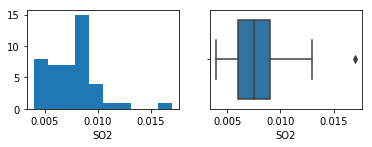

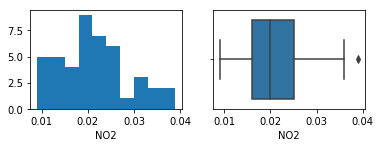

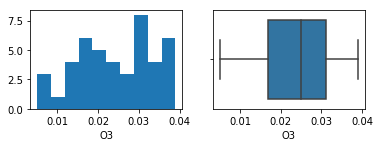

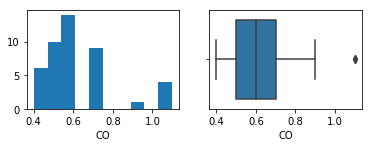

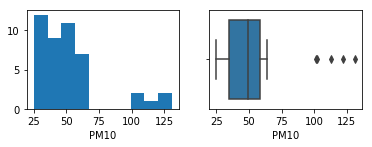

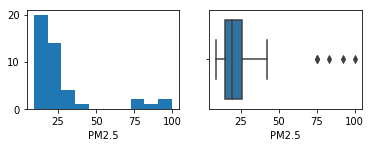

In [23]:
for item in COLUMNS[1:]:
    plot_2charts(data_series=df[item], xlabel=item)

In [24]:
# CO값 차이가 커서,(9로 나눠서 한 그래프에 표시)..['SO2', 'NO2', 'O3', 'CO_mod',]
# df 에 'NEW'칼럼 추가하기 (df.CO값을 복사해서 칸을 늘림)
df['CO_mod'] = pd.Series(df['CO'].copy() / 11, index=df.index)            # CO를    1/12
df['PM10_mod'] = pd.Series(df['PM10'].copy() / 250, index=df.index)       # PM10을  1/250
df['PM2.5_mod'] = pd.Series(df['PM2.5'].copy() / 120, index=df.index)     # PM2.5를 1/120

In [25]:
# 전체 통계정보 보기
df.describe()

,SO2,NO2,O3,CO,PM10,PM2.5,CO_mod,PM10_mod,PM2.5_mod
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,0.007682,0.021068,0.024227,0.622727,52.727273,26.636364,0.056612,0.210909,0.221970
std,0.002399,0.007475,0.009190,0.186602,25.017541,22.618259,0.016964,0.100070,0.188485
min,0.004000,0.009000,0.005000,0.400000,25.000000,9.000000,0.036364,0.100000,0.075000
25%,0.006000,0.016000,0.016750,0.500000,35.000000,14.750000,0.045455,0.140000,0.122917
50%,0.007500,0.020000,0.025000,0.600000,49.000000,19.500000,0.054545,0.196000,0.162500
75%,0.009000,0.025000,0.031000,0.700000,58.250000,26.000000,0.063636,0.233000,0.216667
max,0.017000,0.039000,0.039000,1.100000,131.000000,100.000000,0.100000,0.524000,0.833333


In [26]:
# 데이터간 연계성(Correlation) 확인 

chk_columns = ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5',]
chk_dfs = pd.DataFrame(df[col] for col in chk_columns)

chk_dfs.T.head(5)   # 방향을 transpose() 시켜줘야 함
chk_dfs.T.corr()

,SO2,NO2,O3,CO,PM10,PM2.5
SO2,1.000000,0.592498,-0.556673,0.426872,0.463825,0.422061
NO2,0.592498,1.000000,-0.936579,0.303963,0.258884,0.162867
O3,-0.556673,-0.936579,1.000000,-0.163102,-0.133141,0.003204
CO,0.426872,0.303963,-0.163102,1.000000,0.914988,0.923285
PM10,0.463825,0.258884,-0.133141,0.914988,1.000000,0.970160
PM2.5,0.422061,0.162867,0.003204,0.923285,0.970160,1.000000


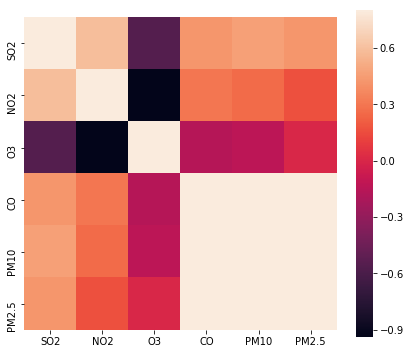

In [27]:
# Correlation Heatmap 확인 (양/음의 관계 강도를 이미지로 보여줌)
# sns.heatmap(chk_dfs.T.corr())

f, ax = plt.subplots(figsize=(7,6))
sns.heatmap(chk_dfs.T.corr(), vmax=.8, square=True);

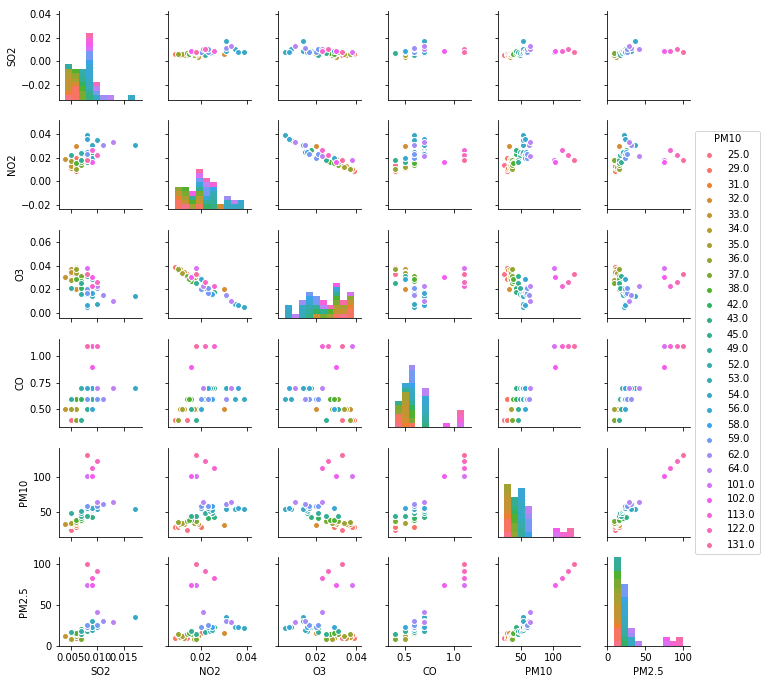

In [28]:
# 전체 분포 및 데이터의 연관성을 보기위해, 타겟 = PM10으로 놓고, 분포확인
# example = https://seaborn.pydata.org/generated/seaborn.pairplot.html

sns.pairplot(chk_dfs.T, hue='PM10', palette="husl", size=1.6)        # size in inches of each pnnel
plt.show()

## 전체 센서값 동향 플로팅
 - ['Time', 'SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']
 - 6개 센서값이 일별 반복패턴을 보임 = 일별 반복패턴의 영향인자? 
 - --> 바람(육풍/해풍)?, 출근시간?, 공장가동시간?, 교통량? 등 ... 확인필요!)
 - 년간 동향을 분석하면 계절별 패턴이 나옴 --> 년간 영향인자 분석!
 - --> 바람(편서풍)?, 기온? 중국의 기상인자? 중국 미세먼지(PM10,2.5)유입, 중앙아시아 사막, 기온(빙점기준)

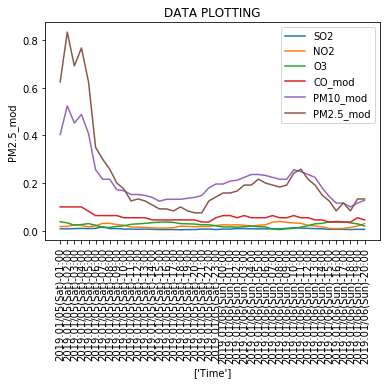

In [29]:
[df_plot(df[col]) for col in ['SO2', 'NO2', 'O3', 'CO_mod','PM10_mod', 'PM2.5_mod',]]
plt.show()

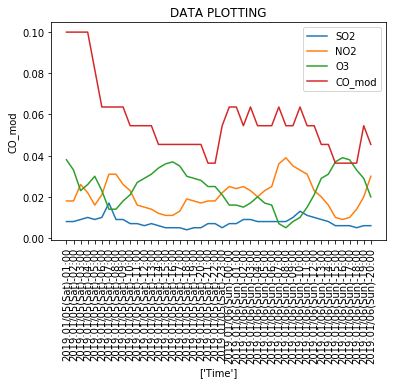

In [30]:
[df_plot(df[col]) for col in ['SO2', 'NO2', 'O3', 'CO_mod',]]
plt.show()

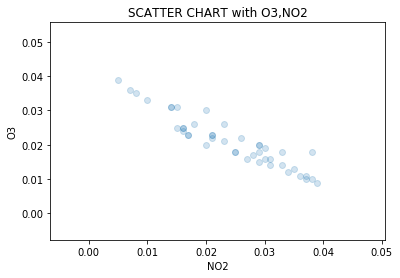

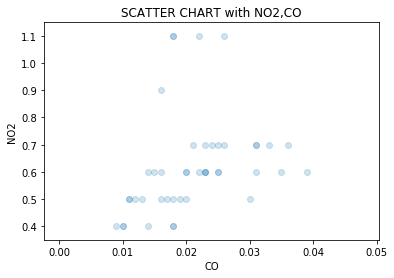

In [31]:
df_scatter(df.O3, df.NO2)
plt.show()

df_scatter(df.NO2, df.CO)
plt.show()

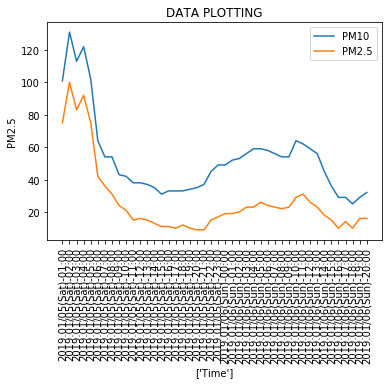

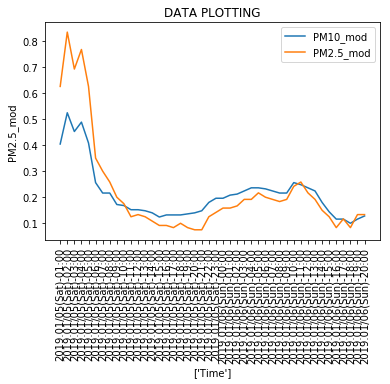

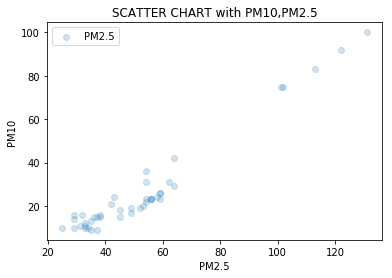

In [32]:
[df_plot(df[col]) for col in ['PM10', 'PM2.5']]
plt.show()

[df_plot(df[col]) for col in ['PM10_mod', 'PM2.5_mod']]
plt.show()

# 스케터는 플립이 필요없음!
df_scatter(df.PM10, df['PM2.5'])
plt.legend()

## 플립하지 말아야 할 그래프

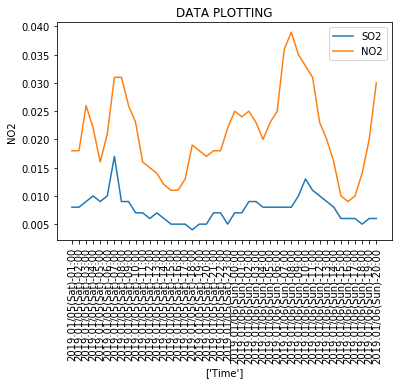

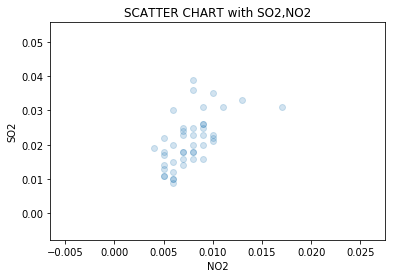

In [33]:
[df_plot(df[col]) for col in ['SO2', 'NO2']]
plt.show()

# 스캐터는 플립할 필요가 없음
df_scatter(df.SO2, df.NO2)
plt.show()

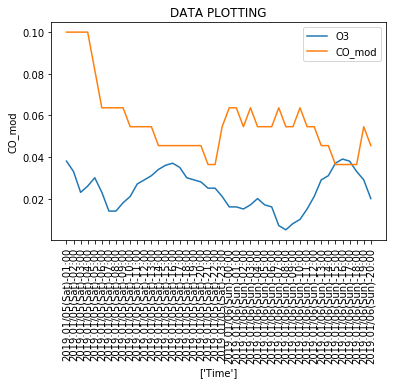

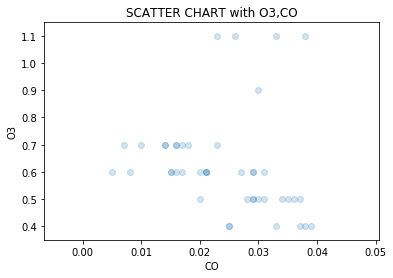

In [34]:
# 전체 플로팅 중에 관심사항만 따로 플로팅 해서 관찰하기
# [df_plot(df[col]) for col in ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']]
# plt.show()

[df_plot(df[col]) for col in ['O3', 'CO_mod',]]
plt.show()

# 스캐터는 플립필요없음!
df_scatter(df.O3, df.CO)
plt.show()

[None, None, None, None, None, None]

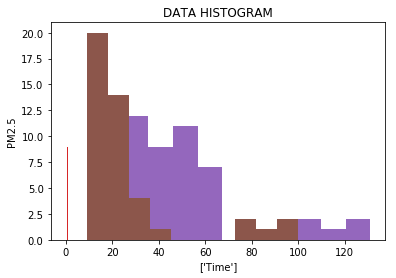

In [35]:
[df_hist(df[col]) for col in ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']]

# http://www.airkorea.or.kr/index
- TODO: 웹에서 이미지 다운 / 또는 캡처해서 실시간 영상제공!

| **대쉬보드** | ---- | **센서값** |
|:-------|:----:|:-------|
| ![](./static/img/air_korea_index.png) | ... | ![](./static/img/air_korea_pm_dashboard.png) | 


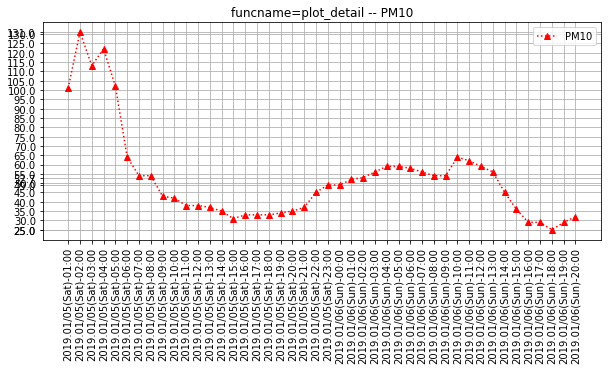

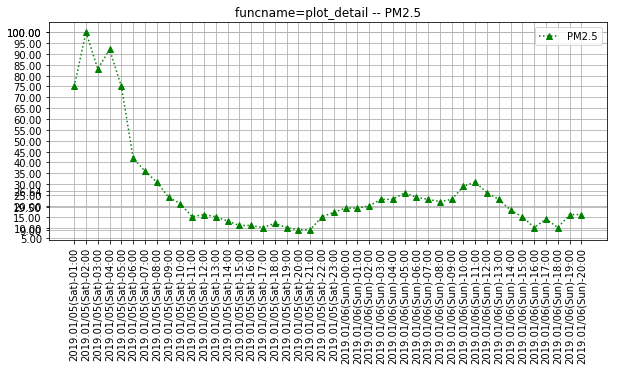

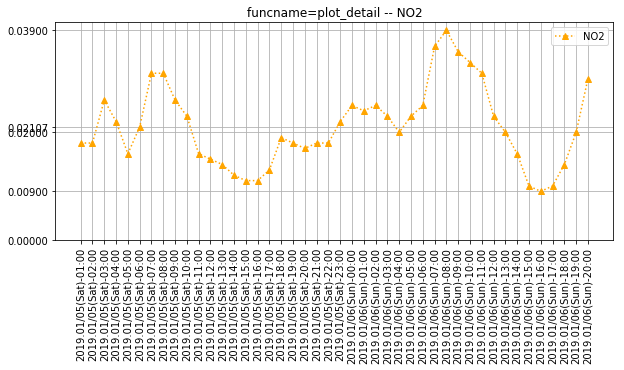

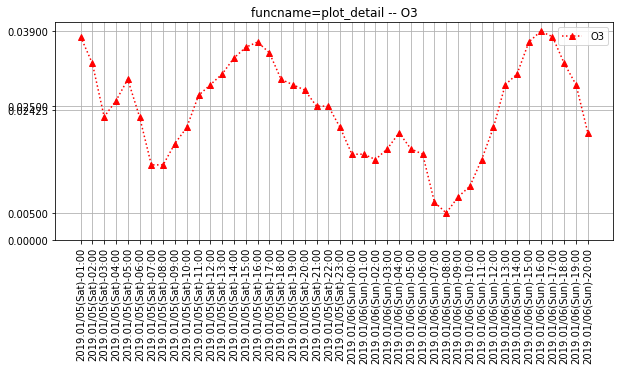

In [36]:
plot_detail(df['PM10'],'red','^',':')
plot_detail(df['PM2.5'],'green','^',':')
plot_detail(df['NO2'],'orange','^',':')
plot_detail(df['O3'],'red','^',':')

# https:// earth.nullschool.net
- 현재 우리나라 현재상황 [지도](http://bit.ly/2SxRmc4)
- TODO: 웹에서 이미지 다운 / 또는 캡처해서 실시간 영상제공!

| **2019 1/4(월)** | **4시간 간격 기상변화** |
|:--:|:--:|
| <img src='./static/img/20190104_0800_nulschool.png'> | <img src='./static/img/20190104_1300_nulschool.png'> |
| 20190104_0800 | 20190104_1300 |
| <img src='./static/img/20190104_1700_nulschool.png'> | <img src='./static/img/20190104_2100_nulschool.png'> |
| 20190104_1700 | 20190104_2100 |
| <img src='./static/img/20190104_2300_nulschool.png'> | <img src='./static/img/20190105_0200_nulschool.png'> |
| 20190104_2300 (?) 갱신주기가 안맞나? 동일영상?!!(3시간) | 20190105_0200 드디어 갱신됬다! |
| <img src='./static/img/20190105_0900_nulschool.png'> | <img src='./static/img/20190105_1200_nulschool.png'> |
| 20190105_0900 격변기! (히드맵 확인) | 20190105_1200 (버거킹에서)?|
| <img src='./static/img/20190105_1600_nulschool.png'> | <img src='./static/img/20190105_2000_nulschool.png'> |
| 20190105_1600 토요스터디 중에 | 20190105_2000 4시간간격 열심히!!(수공예)|
| <img src='./static/img/20190106_1300_nulschool.png'> | <img src='./static/img/20190105_0_nulschool.png'> |
| 20190106_1300 밥먹으러 나옴 | 20190105_|

In [37]:
df.Time.tolist()[-1]

Timestamp('2019-01-06 20:00:00')

In [38]:
SAVE_LOG = datetime.datetime.strftime(df.Time.tolist()[-1], '%Y%m%d_%a_%H00')
SAVE_LOG

'20190106_Sun_2000'

In [39]:
# Data Frame 을 엑셀로 저장한다. (CSV화일)
df.to_csv(f'./static/data/{SAVE_LOG}_air_incheon.csv', sep=',', encoding='utf-8')

In [40]:
import os 

# 점프 투 파이썬 06장 파이썬 프로그래밍, 어떻게 시작
# 06-6 하위 디렉터리 검색하기 ... https://wikidocs.net/39

# abs_data_dir = '/jupyter_air/static/data'
abs_data_dir = 'C:/Users/nitt0/Documents/Github/web_beautifulsoup_scrapping/jupyter_air/static/data'

os.getcwd()
os.chdir(abs_data_dir)
os.listdir('C:/Users/nitt0/Documents/Github/web_beautifulsoup_scrapping/jupyter_air')    # 타겟위치 '검색'

['.ipynb_checkpoints',
 'air_data_collector.ipynb',
 'air_incheon_bs4_00.ipynb',
 'air_incheon_bs4_r01_foat64.ipynb',
 'air_incheon_bs4_r02_reverse.ipynb',
 'air_incheon_overall_r00.ipynb',
 'data_meteo',
 'static',
 'test_pandas.ipynb']